In [1]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from imutils import build_montages
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (64, 64))
    data.append(image)
    labels.append(label)

[INFO] loading images...


In [3]:
data = np.array(data)#, dtype="float") / 255.0
data = data.reshape((data.shape[0], data.shape[1], data.shape[2], 3))
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels, 2)

In [4]:
print(data.shape, labels.shape)

(726, 64, 64, 3) (726, 2)


In [5]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.40, stratify=labels, random_state=42)

In [6]:
opt = Adam(lr=1e-4, decay=1e-4 / 5)

C:\Users\prave\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [7]:
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model

In [8]:
from vit_keras import vit, utils, visualize

model = vit.vit_b16(image_size=64,activation='sigmoid',pretrained=True,include_top=False,pretrained_top=False)
out = Dense(2, activation='softmax')(model.output)
model = Model(model.input, out)
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\vit_keras\utils.py:77: UserWarning: Resizing position embeddings from 24 to 4
  warnings.warn(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
embedding (Conv2D)           (None, 4, 4, 768)         590592    
_________________________________________________________________
reshape (Reshape)            (None, 16, 768)           0         
_________________________________________________________________
class_token (ClassToken)     (None, 17, 768)           768       
_________________________________________________________________
Transformer/posembed_input ( (None, 17, 768)           13056     
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 17, 768), (None,  7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 17, 768), (None,  708787

In [9]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [10]:
H = model.fit(x=trainX, y=trainY, validation_data=(testX, testY),batch_size=32, epochs=5, verbose=1)

Epoch 1/5
14/14 [==============================] - 19s 347ms/step - loss: 0.5703 - accuracy: 0.7655 - val_loss: 0.2114 - val_accuracy: 0.9485
Epoch 2/5
14/14 [==============================] - 2s 150ms/step - loss: 0.1292 - accuracy: 0.9724 - val_loss: 0.0710 - val_accuracy: 0.9863
Epoch 3/5
14/14 [==============================] - 2s 151ms/step - loss: 0.0305 - accuracy: 0.9954 - val_loss: 0.0296 - val_accuracy: 0.9897
Epoch 4/5
14/14 [==============================] - 2s 152ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0216 - val_accuracy: 0.9897
Epoch 5/5
14/14 [==============================] - 2s 150ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0229 - val_accuracy: 0.9897


In [11]:
model.save("weather.h5")

In [12]:
image = cv2.imread("dataset/cyclone/2.jpg")
image = cv2.resize(image, (64, 64))

classes = ['cyclone', 'normal']
attention_map = visualize.attention_map(model=model, image=image)
print('Prediction:', classes[model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()])  

Prediction: cyclone


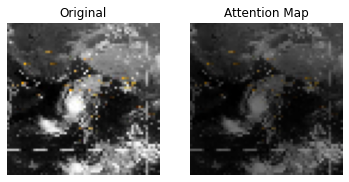

In [13]:
# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)